In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from lattice_utils import (
    MultiFileDataset,
    BinFileDataset,
    xy_hamiltonian,
    corr_2d,
    deformed_corr_2d,
    reweight,
    plot_hists,
    helicity_modulus,
    mean_squared_mag
)
from stats import bin_bootstrap

from models import UNet, Conv1Layer
from engines import train

### To-dos
- Show improvement due to 1 layer network using histograms
- Bootstrap errors on helicity modulus, magnetization, and heat capacity
- Bootstrap errors on undeformed projected correlation
- Bootstrap errors on deformed projected/unprojected correlation
- Compare variance against separation for both

In [2]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [3]:
kernel_size = 19
lat_size = 128

In [4]:
train_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/val")

In [24]:
temps_range = np.arange(0.8, 1.01, 0.01)

loaders = []

for temp in temps_range:
    fname = f"L=128_cluster_T={temp:.4f}_configs.bin"
    train_folder = "L_128/U-Net/train"
    val_folder = "L_128/U-Net/val"

    train_ds = BinFileDataset(
        folder=train_folder,
        fname=fname,
        seps=(lat_size // 2, lat_size // 2),
        random_seps=False
    )
    val_ds = BinFileDataset(
        folder=val_folder,
        fname=fname,
        seps=(lat_size // 2, lat_size // 2),
        random_seps=False
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=32,
        shuffle=True,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=4096,
        shuffle=False,
        pin_memory=True,
        drop_last=False
    )

    loaders.append((train_loader, val_loader))

### Basic Observables

In [60]:
helicity_moduli = []
mean_squared_mags = []
energies = []

for i in range(len(train_multi_file_ds.datasets)):
    print(f"Dataset {i + 1}/{len(train_multi_file_ds.datasets)}")

    ds = train_multi_file_ds.datasets[i]
    temp = torch.tensor([ds.T], dtype=torch.float32, device='cpu')
    loader = DataLoader(ds, batch_size=128, shuffle=False)

    helicity_modulus_samples = []
    mean_squared_mags_samples = []
    energy_samples = []

    for batch, inputs in enumerate(loader):
        inputs = tuple(x.to('cpu') for x in inputs)
        lats = inputs[0]
        helicity_modulus_samples.append(helicity_modulus(lats, temp))
        mean_squared_mags_samples.append(mean_squared_mag(lats))
        energy_samples.append(xy_hamiltonian(lats))

    helicity_moduli.append(np.concat(helicity_modulus_samples, axis=0))
    mean_squared_mags.append(np.concat(mean_squared_mags_samples, axis=0))
    energies.append(np.concat(energy_samples, axis=0))

Dataset 1/41
Dataset 2/41
Dataset 3/41
Dataset 4/41
Dataset 5/41
Dataset 6/41
Dataset 7/41
Dataset 8/41
Dataset 9/41
Dataset 10/41
Dataset 11/41
Dataset 12/41
Dataset 13/41
Dataset 14/41
Dataset 15/41
Dataset 16/41
Dataset 17/41
Dataset 18/41
Dataset 19/41
Dataset 20/41
Dataset 21/41
Dataset 22/41
Dataset 23/41
Dataset 24/41
Dataset 25/41
Dataset 26/41
Dataset 27/41
Dataset 28/41
Dataset 29/41
Dataset 30/41
Dataset 31/41
Dataset 32/41
Dataset 33/41
Dataset 34/41
Dataset 35/41
Dataset 36/41
Dataset 37/41
Dataset 38/41
Dataset 39/41
Dataset 40/41
Dataset 41/41


In [61]:
helicity_moduli = np.stack(helicity_moduli)
mean_squared_mags = np.stack(mean_squared_mags)
energies = np.stack(energies)

In [62]:
np.save("obs/helicity_moduli.npy", helicity_moduli)
np.save("obs/mean_squared_mags.npy", mean_squared_mags)
np.save("obs/energies.npy", energies)

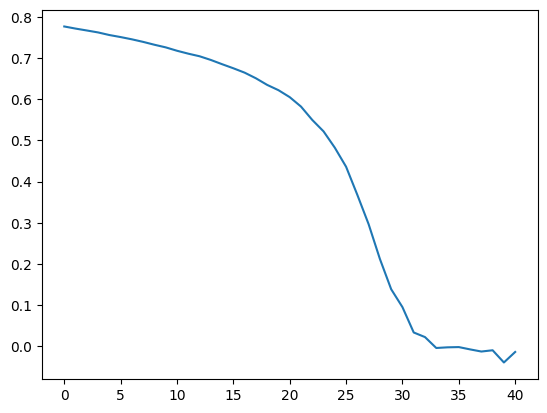

In [17]:
plt.plot(helicity_moduli.mean(axis=1))

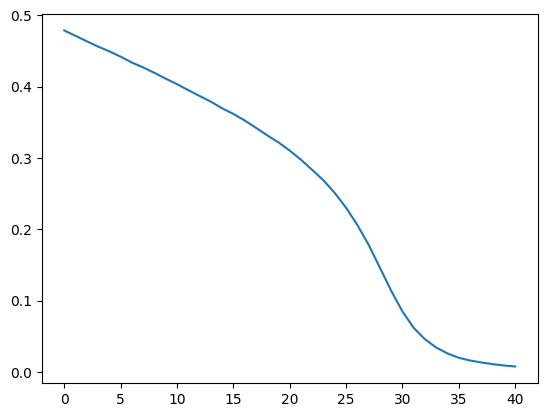

In [18]:
plt.plot(mean_squared_mags.mean(axis=1))

<function stats.bin_bootstrap(data, stat, nboot, level)>

### 1-Layer Convolutional Network

In [ ]:
# conv1layer.load_state_dict(torch.load("conv1layer_128.pth"))

Conv1Layer(
  (conv): Conv2d(1, 1, kernel_size=(19, 19), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

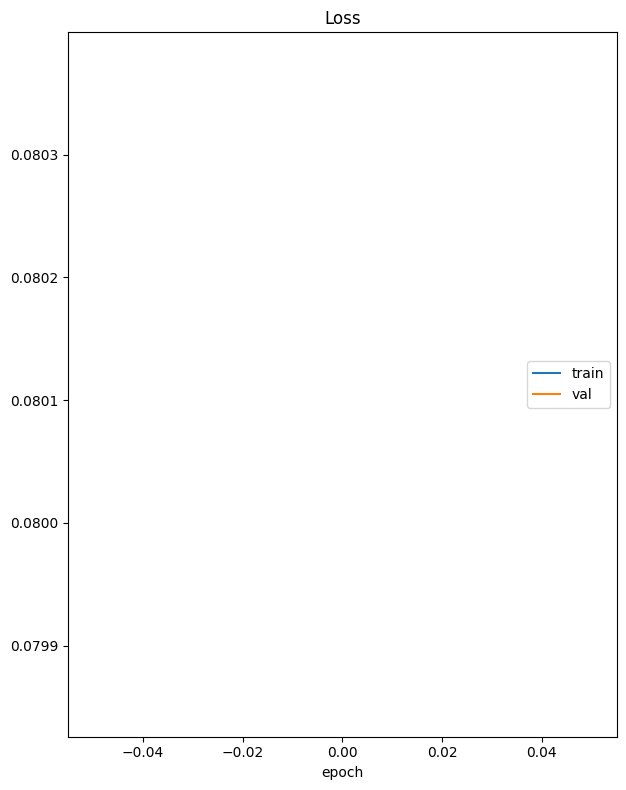

Loss
	train            	 (min:    0.080, max:    0.080, cur:    0.080)
	val              	 (min:    0.080, max:    0.080, cur:    0.080)


In [25]:
undef_1layer = []
def_1layer = []

conv1layer = Conv1Layer(lat_size=lat_size, kernel_size=kernel_size)

for i in range(len(loaders)):

    single_loader, single_val_loader = loaders[i]

    conv1layer.to(device)

    optim = Adam(conv1layer.parameters(), lr=1e-3)
    # scheduler = CosineAnnealingLR(optim, 25, 1e-5)

    epochs = 1
    if i == 0:
        epochs = 30

    train(
        model=conv1layer,
        loader=single_loader,
        optimizer=optim,
        # scheduler=scheduler,
        epochs=epochs,
        device=device,
        val_loader=single_val_loader,
    )

    def_samples = []
    undef_samples = []

    with torch.no_grad():
        conv1layer.eval()

        for batch, inputs in enumerate(single_val_loader):
            inputs = tuple(x.to(device) for x in inputs)
            lats, temp, x, y = inputs

            shifts = conv1layer(temp, x, y)

            deformed_corr = deformed_corr_2d(lats, temp, shifts, x, y)
            corr = corr_2d(lats, x, y)

            def_samples.append(deformed_corr.cpu().detach().numpy())
            undef_samples.append(corr.cpu().detach().numpy())

    def_1layer.append(np.concatenate(def_samples, axis=0))
    undef_1layer.append(np.concatenate(undef_samples, axis=0))

def_1layer = np.stack(def_1layer)
undef_1layer = np.stack(undef_1layer)

array([[ 0.55560195+0.01840074j,  0.5645401 -0.04305153j,
         0.58182055+0.06560975j, ...,  0.44163692+0.33594543j,
         0.4985837 +0.23575635j,  0.4414521 +0.30558264j],
       [ 0.51632226-0.00457118j,  0.43996277-0.25885233j,
         0.5277467 +0.10086858j, ...,  0.5018427 -0.24187225j,
         0.5285554 -0.11930794j,  0.47040507-0.25829223j],
       [-0.00665321-0.4538016j ,  0.42582524+0.2900492j ,
         0.3824749 +0.35069856j, ...,  0.5121647 -0.02501747j,
         0.48857224+0.24922308j,  0.3992047 -0.36465636j],
       ...,
       [ 0.0521905 -0.43881908j,  0.39521548-0.0047375j ,
         0.38111514+0.10767044j, ..., -0.09802252-0.30593437j,
         0.0097915 -0.3630126j , -0.0216912 -0.3603276j ],
       [ 0.28261417+0.2968083j ,  0.36088425+0.19594015j,
         0.14049424-0.38371366j, ..., -0.30611578-0.21214235j,
         0.37668216+0.14442076j,  0.26442987+0.30361614j],
       [-0.01731233-0.45436528j, -0.29541427+0.3073648j ,
         0.01320335+0.4077705j

In [26]:
np.save("corrs/1layer/deformed_corrs.npy", def_1layer)
np.save("corrs/1layer/undeformed_corrs.npy", undef_1layer)

In [ ]:
# torch.save(conv1layer.state_dict(), "conv1layer_128.pth")

In [ ]:
conv1layer.eval()

single_loader = DataLoader(train_single_file_ds, batch_size=1024)
temp = torch.tensor([1.1], device=device, dtype=torch.float32)
k = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
j = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

initial = []
deformed = []

shift_field = conv1layer(temp, k, j)

with torch.no_grad():
    for batch, inputs in enumerate(single_loader):
        inputs = tuple(input.to(device) for input in inputs)
        lats = inputs[0]
        # print(shift_field.size())
        deformed.append(deformed_corr_2d(lats, temp, shift_field, k, j))
        initial.append(corr_2d(lats, k, j))

initial = torch.cat(initial, dim=0).cpu()
deformed = torch.cat(deformed, dim=0).cpu()

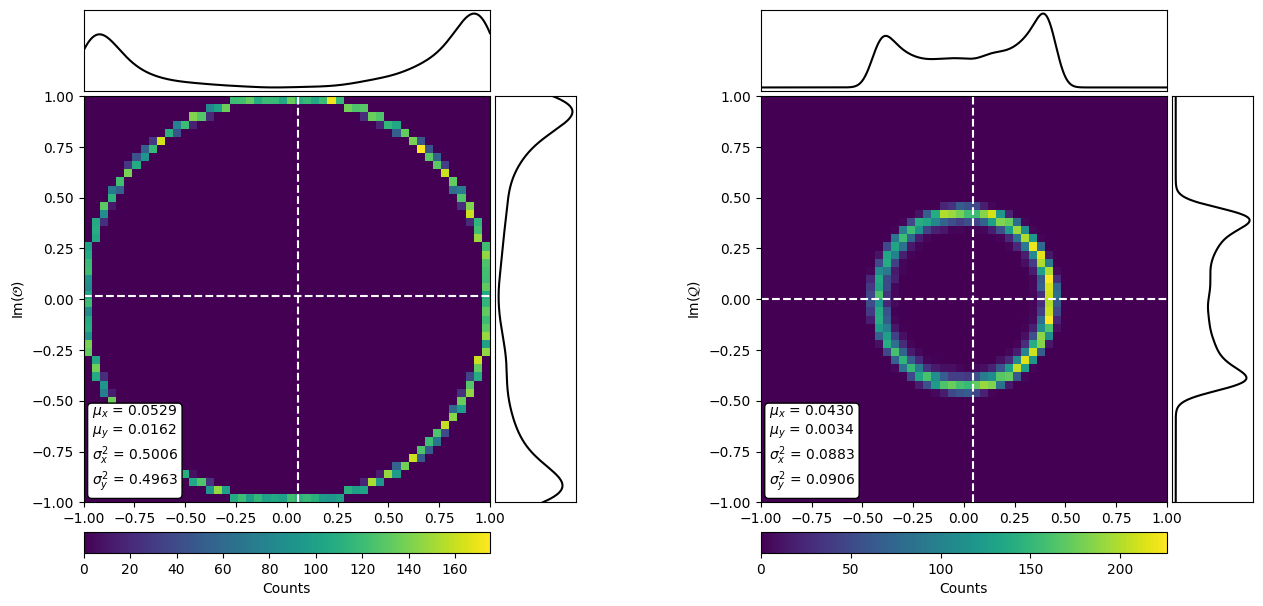

In [ ]:
fig = plot_hists(initial, deformed)

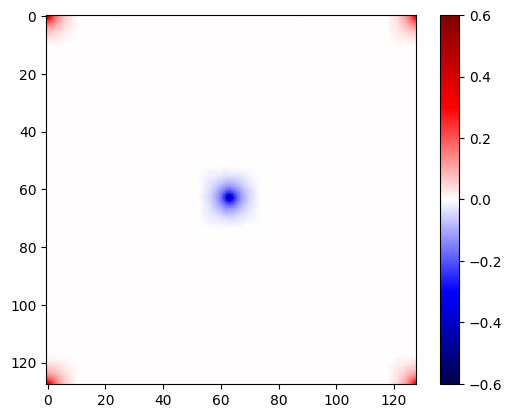

In [ ]:
plt.imshow(shift_field.squeeze().cpu().detach().numpy(), cmap="seismic")
plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{\mathbf{x}\in\Lambda}\int_{t_0}^{t_1}dt\,\rho(t) \cdot \mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right]$$

$$\mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right] = \left[\mathrm{Re}\left\langle \mathcal{Q(\mathbf{x},t)} \right\rangle\right]^2$$

$$\mathcal{Q}(\mathbf{x},t)=\exp\left[i(\tilde{\theta}(\mathbf{x},t) - \tilde{\theta}(\mathbf{0},t))\right]\cdot\exp\left[{-\beta(H(\tilde{\Omega})-H(\Omega))}\right]$$

$$\Omega=\left\{\theta(\mathbf{x}) | \mathbf{x}\in \Lambda\right\},\, \tilde{\theta}(\mathbf{x}) = \theta(\mathbf{x},t) + i\Delta(\mathbf{x,t})$$

With $\rho(t)$ some probability density that has support over $[t_0,t_1]$. Currently using a uniform sampling in $\beta$ rather than $t$, which amounts to the change of variables $d\beta=-dT/T^2$

In [36]:
unet = UNet(lat_size=128, min_size=16)
unet.to(device)
# unet.load_state_dict(torch.load("unet_state_dict_128.pth")) # With min size 4

UNet(
  (encoder_expand_convs): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (encoder_refine_convs): ModuleList(
    (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (decoder_reduce_convs): ModuleList(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(8, 4, 

In [ ]:
training_sample_weights = reweight(
    torch.stack([train_multi_file_ds[i][1] for i in range(len(train_multi_file_ds))]).detach().numpy(),
    dist=lambda x: x**-2,
)

np.save("L_128/U-Net/train_sample_weights.npy", training_sample_weights)

In [37]:
training_sample_weights = np.load("L_128/U-Net/train_sample_weights.npy")
sampler = WeightedRandomSampler(training_sample_weights, num_samples=len(train_multi_file_ds), replacement=True)

In [38]:
multi_train_loader = DataLoader(train_multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
multi_val_loader = DataLoader(val_multi_file_ds, batch_size=256, shuffle=False, pin_memory=True)

optim = Adam(unet.parameters(), lr=1e-3)
# scheduler = CosineAnnealingWarmRestarts(optim, 2500, eta_min=1e-5)

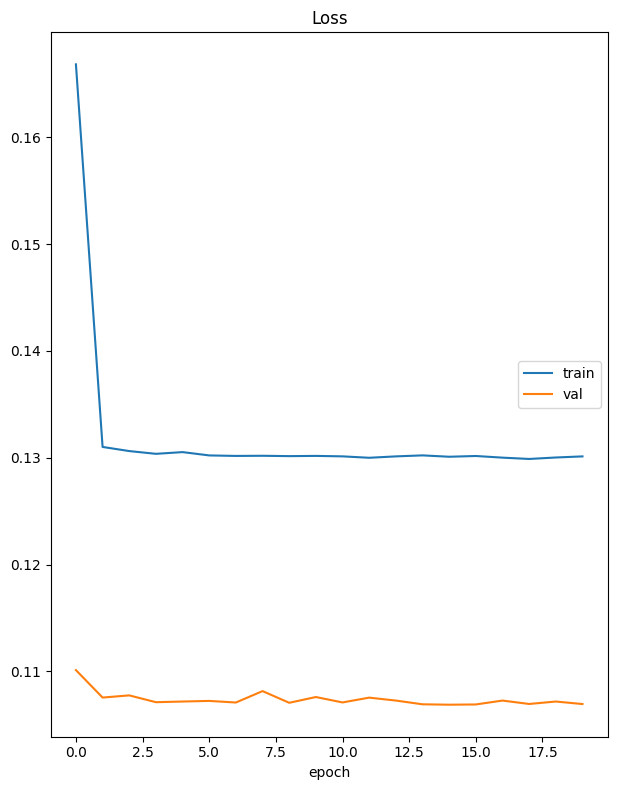

Loss
	train            	 (min:    0.130, max:    0.167, cur:    0.130)
	val              	 (min:    0.107, max:    0.110, cur:    0.107)


In [39]:
unet.train()

train(
    model=unet,
    loader=multi_train_loader,
    optimizer=optim,
    # scheduler=scheduler,
    epochs=20,
    device=device,
    val_loader=multi_val_loader,
)

In [40]:
torch.save(unet.state_dict(), "unet_state_dict_128_min_16.pth")

### Post Processing of Data

In [ ]:
init_corrs, def_corrs = torch.load("corrs_128.pth")

In [ ]:
x_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency
y_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency

In [31]:
unet.eval()

init_corrs = []
def_corrs = []

x = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
y = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

for k in range(len(val_multi_file_ds.datasets)):
    print(f"Dataset {k + 1}/{len(val_multi_file_ds.datasets)}")

    ds = val_multi_file_ds.datasets[k]

    loader = DataLoader(ds, batch_size=100, shuffle=False)

    T = torch.tensor([ds.T], device=device, dtype=torch.float32)

    init_samples = []
    def_samples = []

    for batch, inputs in enumerate(loader):
        inputs = tuple(input.to(device) for input in inputs)
        lats = inputs[0]

        with torch.no_grad():
            init_samples.append(corr_2d(lats, x, y))
            def_samples.append(deformed_corr_2d(lats, T, unet(T, x, y), x, y))

    init_samples = torch.cat(init_samples, dim=0).cpu()
    def_samples = torch.cat(def_samples, dim=0).cpu()

    init_corrs.append(init_samples)
    def_corrs.append(def_samples)

init_corrs = torch.stack(init_corrs, dim=0)
def_corrs = torch.stack(def_corrs, dim=0)

Dataset 1/21
Dataset 2/21
Dataset 3/21
Dataset 4/21
Dataset 5/21
Dataset 6/21
Dataset 7/21
Dataset 8/21
Dataset 9/21
Dataset 10/21
Dataset 11/21
Dataset 12/21
Dataset 13/21
Dataset 14/21
Dataset 15/21
Dataset 16/21
Dataset 17/21
Dataset 18/21
Dataset 19/21
Dataset 20/21
Dataset 21/21


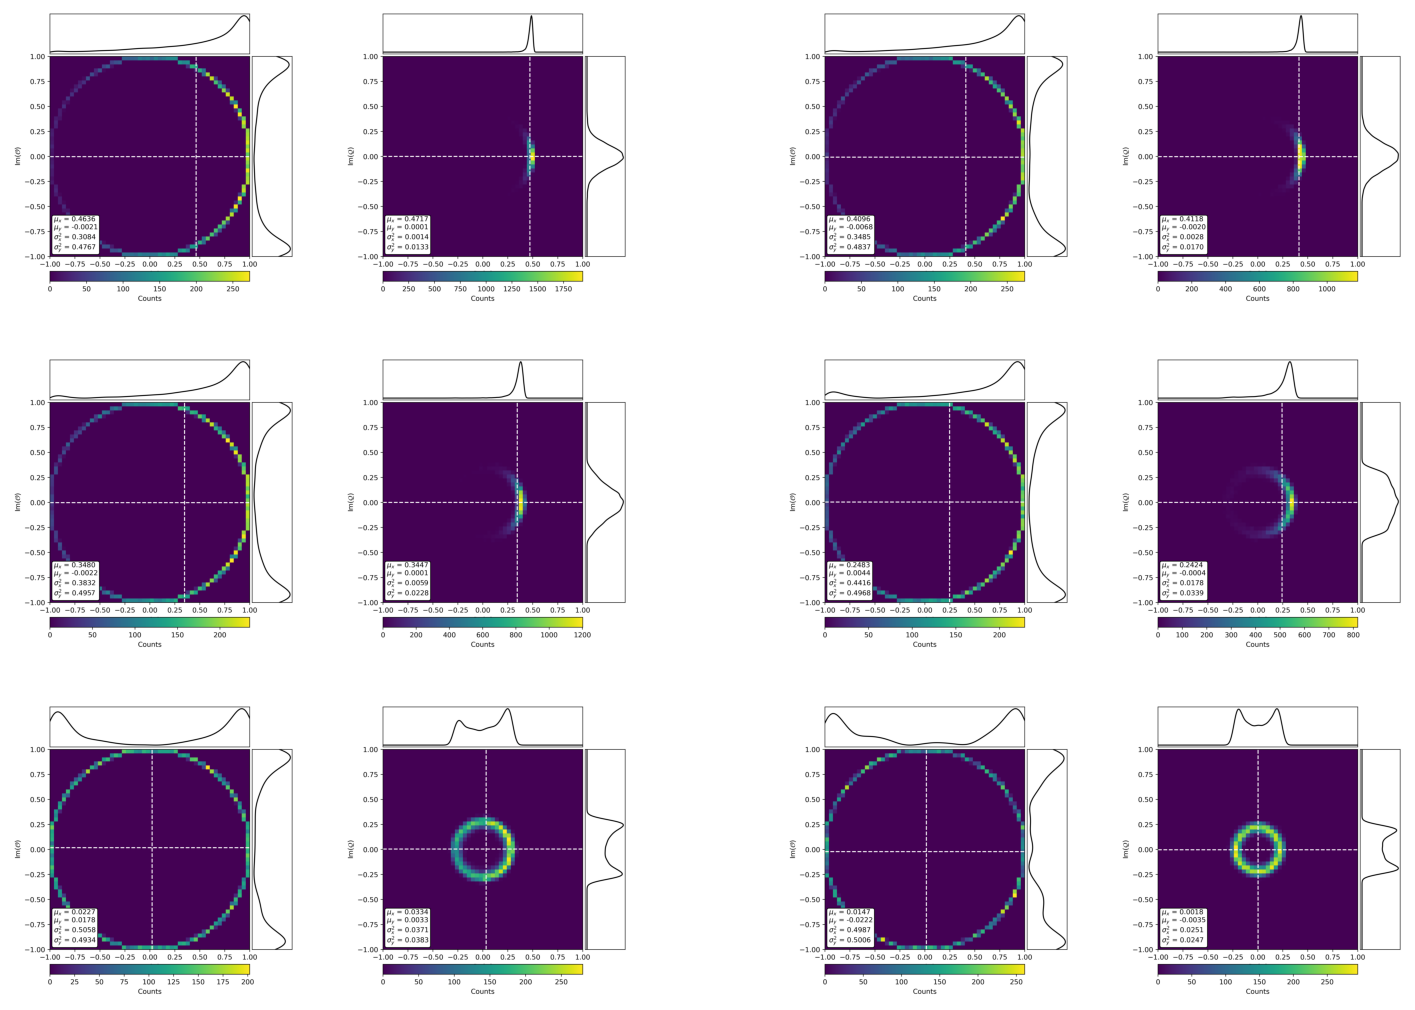

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
from io import BytesIO
from PIL import Image


def plot_hists_grid_from_function(initials, deformeds, ncols=3):
    """
    Render each plot_hists() into an image and tile them in a grid.
    """

    N = len(initials)
    nrows = int(np.ceil(N / ncols))
    images = []

    for i in range(N):
        # Get the figure from plot_hists
        fig = plot_hists(initials[i], deformeds[i])

        # Render the figure to a PNG buffer
        buf = BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight", dpi=400)
        plt.close(fig)
        buf.seek(0)

        img = Image.open(buf).convert("RGB")
        images.append(img)

    # Now tile all rendered images in one big figure
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 9, nrows * 6), constrained_layout=False)
    axs = np.array(axs).reshape(-1)

    for i, ax in enumerate(axs):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis("off")

    # Adjust vertical & horizontal spacing
    plt.subplots_adjust(hspace=-0.5, wspace=0.25)  # reduce these as needed

    plt.show()


l = init_corrs.size(0)  # Number of seps
plot_hists_grid_from_function(init_corrs[0, ::4, :], def_corrs[0, ::4, :], ncols=2)

In [73]:
unet.eval()

k = torch.tensor([lat_size // 2], device=device, dtype=torch.float32)
j = torch.tensor([lat_size // 2], device=device, dtype=torch.float32)

tempwise_shift_fields = []

temps_range = np.linspace(0.7, 1.1, 41)

for T in temps_range:

    print(f"Processing temperature: {T}")

    with torch.no_grad():

        temp = torch.tensor([T], device=device, dtype=torch.float32)

        initial = []
        deformed = []

        shift_field = unet(temp, k, j)

        tempwise_shift_fields.append(shift_field.cpu())

tempwise_shift_fields = torch.cat(tempwise_shift_fields, dim=0)
tempwise_shift_fields_centred = tempwise_shift_fields - tempwise_shift_fields.mean(dim=(1, 2), keepdim=True)

Processing temperature: 0.7
Processing temperature: 0.71
Processing temperature: 0.72
Processing temperature: 0.73
Processing temperature: 0.74
Processing temperature: 0.75
Processing temperature: 0.76
Processing temperature: 0.77
Processing temperature: 0.78
Processing temperature: 0.79
Processing temperature: 0.8
Processing temperature: 0.81
Processing temperature: 0.8200000000000001
Processing temperature: 0.8300000000000001
Processing temperature: 0.84
Processing temperature: 0.85
Processing temperature: 0.86
Processing temperature: 0.87
Processing temperature: 0.88
Processing temperature: 0.89
Processing temperature: 0.9
Processing temperature: 0.91
Processing temperature: 0.92
Processing temperature: 0.93
Processing temperature: 0.9400000000000001
Processing temperature: 0.9500000000000001
Processing temperature: 0.9600000000000001
Processing temperature: 0.97
Processing temperature: 0.98
Processing temperature: 0.99
Processing temperature: 1.0
Processing temperature: 1.01
Proces

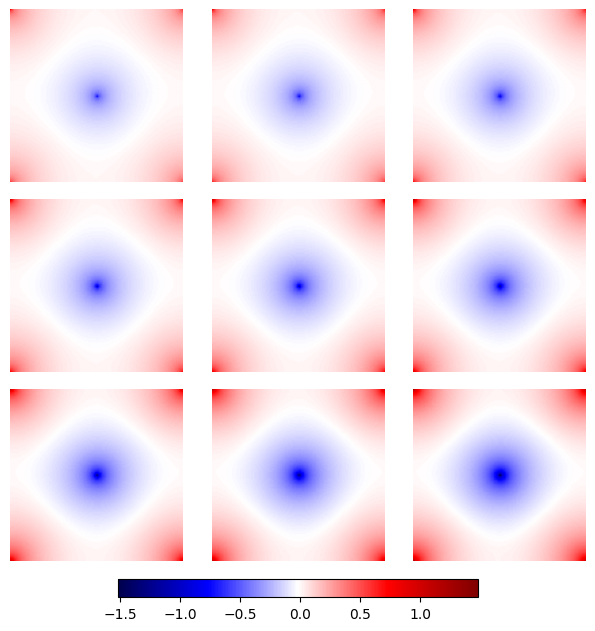

In [74]:
def plot_tensor_grid(tensor):
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"

    # Convert to numpy
    array = tensor.detach().cpu().numpy()

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    # Create figure and subplots with no gaps
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(2 * ncols, 2 * nrows),
        sharex=True,
        sharey=True,
        gridspec_kw=dict(wspace=0.025, hspace=0.1),
    )

    axes = axes.flat

    # Common color scale
    vmin = array.min()
    vmax = array.max()

    im = None
    for i in range(N):
        im = axes[i].imshow(array[i], vmin=vmin, vmax=vmax, cmap="seismic")
        axes[i].axis("off")

    for i in range(N, len(axes)):
        axes[i].axis("off")

    # Horizontal colorbar
    cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.03])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal")

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0.08)
    plt.show()


tensor = tempwise_shift_fields_centred[::5]
plot_tensor_grid(tensor)

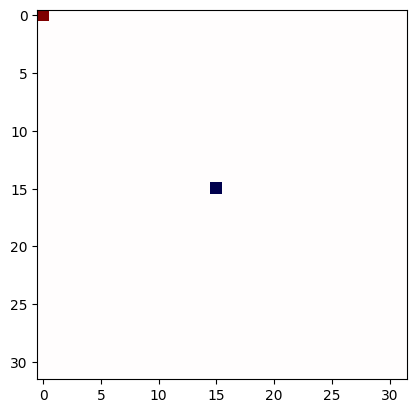

In [59]:
unsmeared = np.zeros((32, 32))
unsmeared[15, 15] = -1
unsmeared[0, 0] = 1

plt.imshow(unsmeared, cmap='seismic')

/tmp/ipykernel_442737/227097855.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(tempwise_shift_fields_centred[-1]/smeared, cmap='seismic')
/tmp/ipykernel_442737/227097855.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(tempwise_shift_fields_centred[-1]/smeared, cmap='seismic')


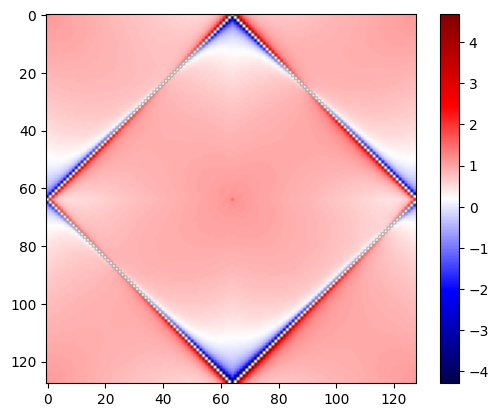

In [83]:
L = 128

smeared = np.zeros((L, L))

for x in range(L):
    for y in range(L):
        p = np.array([x, y])
        r = np.array([L//2, L//2])

        d1 = p 
        d2 = p - r

        d1 = d1 - L * np.round(d1 / L)
        d2 = d2 - L * np.round(d2 / L)

        if not np.all(d1 == 0) and not np.all(d2 == 0):
            smeared[y, x] = -np.log(np.sqrt(np.sum(d1**2))) + np.log(np.sqrt(np.sum(d2**2)))

smeared = smeared - smeared.mean()
smeared = smeared / np.abs(smeared).max()
smeared[0, 0] = 1  # Set the center to 1 for visualization  
smeared[L // 2, L // 2] = -1  # Set a point to -1 for visualization

# plt.imshow(smeared, cmap='seismic')
plt.imshow(tempwise_shift_fields_centred[-1]/smeared, cmap='seismic')
plt.colorbar()


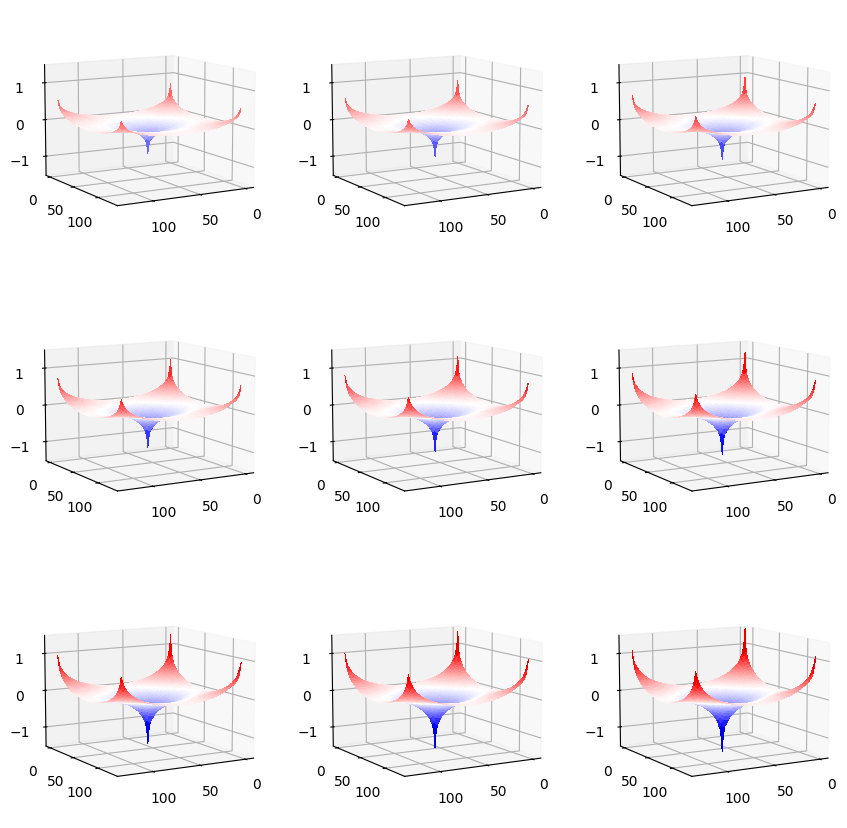

In [ ]:
def plot_tensor_grid_3d(tensor, stride=1):
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"

    array = tensor.detach().cpu().numpy()

    # Downsample if needed
    array = array[::stride]
    N = array.shape[0]

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    fig = plt.figure(figsize=(3.5 * ncols, 3.5 * nrows))

    # Coordinate grid
    x = np.arange(L1)
    y = np.arange(L2)
    X, Y = np.meshgrid(x, y)

    vmin = array.min()
    vmax = array.max()

    for i in range(N):
        ax = fig.add_subplot(nrows, ncols, i + 1, projection="3d")
        ax.plot_surface(X, Y, array[i], cmap="seismic", vmin=vmin, vmax=vmax, linewidth=0, antialiased=False)
        ax.set_zlim(vmin, vmax)
        # ax.axis('off')  # optional: remove axes

        ax.view_init(elev=10, azim=60)

    # plt.tight_layout()
    plt.show()


tensor = tempwise_shift_fields_centred[::5]
plot_tensor_grid_3d(tensor)

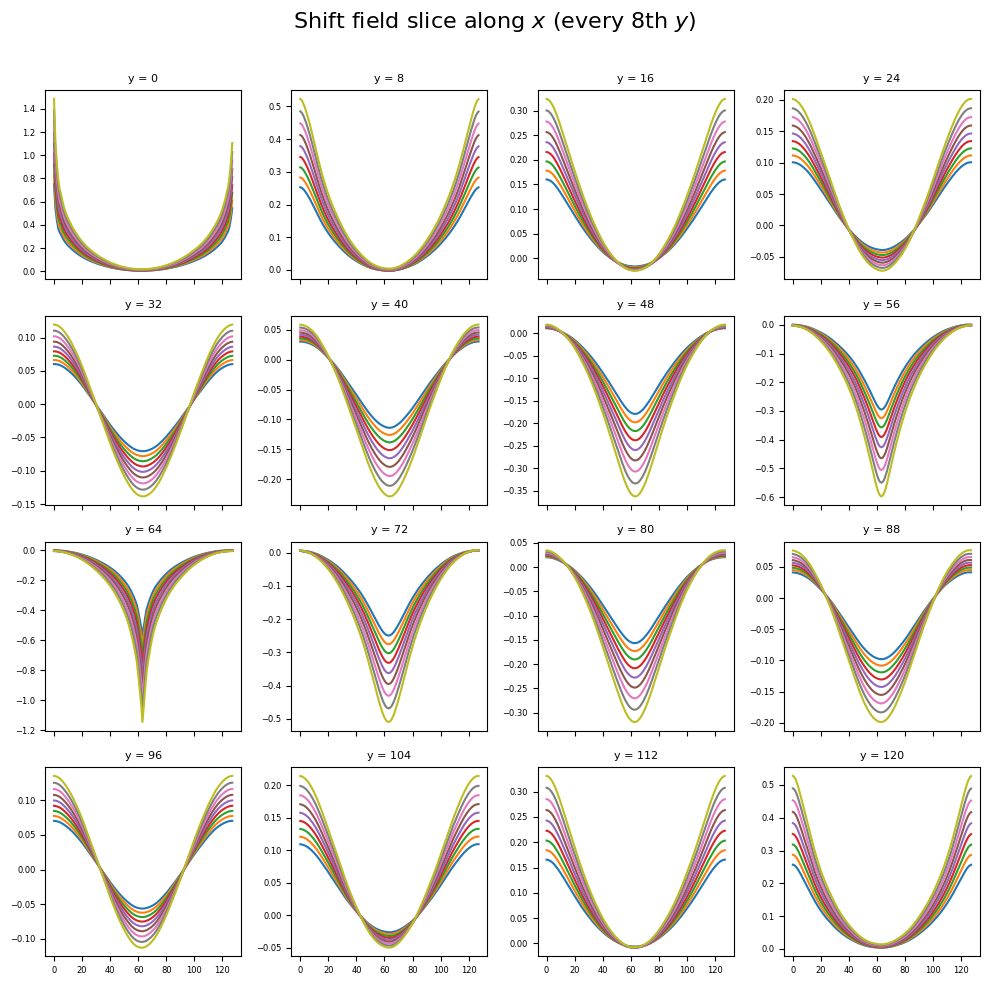

In [ ]:
i_values = list(range(0, lat_size, 8))  # every 4th i

nplots = len(i_values)
ncols = int(np.ceil(np.sqrt(nplots)))
nrows = int(np.ceil(nplots / ncols))

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(ncols * 2.5, nrows * 2.5),
    sharex=True,
    # sharey=True
)

axes = axes.flat

for idx, i in enumerate(i_values):
    data = tempwise_shift_fields_centred[::5, i, :]
    axes[idx].plot(data.T.cpu().numpy())
    axes[idx].set_title(f"y = {i}", fontsize=8)
    axes[idx].tick_params(labelsize=6)

# Turn off unused axes
for j in range(nplots, len(axes)):
    axes[j].axis("off")

fig.suptitle("Shift field slice along $x$ (every 8th $y$)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [8]:
val_temps = np.array([ds.T for ds in val_multi_file_ds.datasets])
x_seps = np.arange(lat_size // 8, 7 * lat_size // 8 + 1, 4)  # every 2nd separation for efficiency
# y_seps = np.arange(lat_size // 8, 7 * lat_size // 8 + 1, 2)  # every 2nd separation for efficiency
# x_seps = np.arange(lat_size)
y_seps = np.arange(lat_size)

In [9]:
def undeformed_projected_corrs(lats, x_seps):

    phis = torch.exp(1j * lats).sum(dim=1)  # sum over y-axis
    # shape should now be (B, L)
    corrs = np.zeros((phis.size(0), x_seps.size), dtype=np.float32)

    for i in range(len(x_seps)):
        dt = x_seps[i]

        avg = torch.zeros_like(phis[:, 0], dtype=torch.complex64)

        for j in range(lat_size):
            avg += phis[:, j] * phis[:, (j + dt) % lat_size].conj()

        avg /= lat_size
        corrs[:, i] = avg.cpu().numpy().real

    return corrs

In [10]:
with torch.no_grad():

    batch_size = 100

    undeformed_proj = []

    for k in range(len(val_multi_file_ds.datasets)):
        print(f"Dataset {k + 1}/{len(val_multi_file_ds.datasets)}")

        ds = val_multi_file_ds.datasets[k]

        loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

        samples = []

        for batch, inputs in enumerate(loader):

            inputs = tuple(inp.to(device) for inp in inputs)
            lats = inputs[0]

            samples.append(undeformed_projected_corrs(lats, x_seps))

        samples = np.concatenate(samples, axis=0)
        undeformed_proj.append(samples)

    undeformed_proj = np.stack(undeformed_proj)

undeformed_proj.shape

Dataset 1/21
Dataset 2/21
Dataset 3/21
Dataset 4/21
Dataset 5/21
Dataset 6/21
Dataset 7/21
Dataset 8/21
Dataset 9/21
Dataset 10/21
Dataset 11/21
Dataset 12/21
Dataset 13/21
Dataset 14/21
Dataset 15/21
Dataset 16/21
Dataset 17/21
Dataset 18/21
Dataset 19/21
Dataset 20/21
Dataset 21/21


array([[[7901.8447 , 7812.7437 , 7706.287  , ..., 7706.287  ,
         7812.7437 , 7901.844  ],
        [7320.455  , 7258.5513 , 7203.276  , ..., 7203.277  ,
         7258.551  , 7320.455  ],
        [5432.497  , 5401.7476 , 5354.301  , ..., 5354.301  ,
         5401.747  , 5432.4976 ],
        ...,
        [7289.1665 , 7209.7935 , 7154.8774 , ..., 7154.878  ,
         7209.794  , 7289.1665 ],
        [7688.4326 , 7615.7734 , 7595.1694 , ..., 7595.1704 ,
         7615.7725 , 7688.433  ],
        [7888.7275 , 7835.806  , 7824.4795 , ..., 7824.4795 ,
         7835.8057 , 7888.7295 ]],

       [[6103.431  , 6028.337  , 5948.023  , ..., 5948.022  ,
         6028.338  , 6103.4336 ],
        [5479.7847 , 5481.9653 , 5476.8125 , ..., 5476.814  ,
         5481.965  , 5479.785  ],
        [6484.5024 , 6449.587  , 6413.874  , ..., 6413.8765 ,
         6449.589  , 6484.5044 ],
        ...,
        [6993.142  , 6857.6206 , 6806.633  , ..., 6806.6323 ,
         6857.6196 , 6993.1426 ],
        [735

In [13]:
np.save("undeformed_proj_128.npy", undeformed_proj / lat_size,)

In [9]:
torch.cuda.empty_cache()

In [26]:
deformed_corr_2d_grid = np.load("deformed_corr_2d_grid_2.npy")
corr_2d_grid = np.load("corr_2d_grid.npy_2.npy")

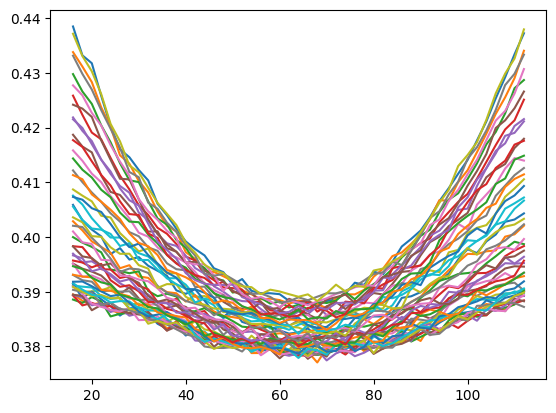

In [40]:
plt.plot(x_seps, deformed_corr_2d_grid[0, :, :])

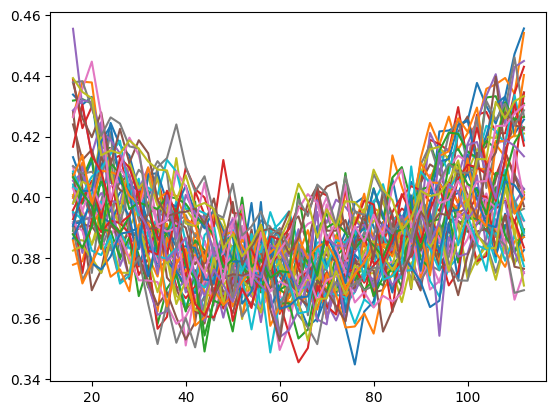

In [41]:
plt.plot(x_seps, corr_2d_grid[0, :, :])

In [ ]:
def compute_correlation(corr_2d_grid, x_seps, y_seps, dr, Lx, Ly):
    """
    corr_2d_grid: 2D array of shape (len(x_range), len(y_range)),
                  storing C(x, y) where x ∈ [Lx/4, 3Lx/4], same for y.
    dr: radial bin width
    Lx, Ly: lattice dimensions
    """

    # Inclusive coordinate ranges (subregion)
    x_range = x_seps
    y_range = y_seps

    # print(x_range)

    # print(x_range.size)

    corr_bins = {}

    for ix, x in enumerate(x_range):
        for iy, y in enumerate(y_range):
            # Wrapped distance from (0, 0) using minimum image convention
            dx = min(x % Lx, (-x) % Lx)
            dy = min(y % Ly, (-y) % Ly)
            r = np.sqrt(dx**2 + dy**2)

            # Bin by radial distance
            bin_index = int(np.floor(r / dr))
            if bin_index not in corr_bins:
                corr_bins[bin_index] = []

            # print(ix, x, iy, y)
            corr_bins[bin_index].append(corr_2d_grid[ix, iy])

    # Convert to sorted arrays
    sorted_bins = sorted(corr_bins.items())
    r_vals = np.array([dr * (k + 0.5) for k, _ in sorted_bins])
    corr_lists = [v for _, v in sorted_bins]

    return r_vals, corr_lists

In [ ]:
r, c_r = compute_correlation(corr_2d_grid[0], x_seps, y_seps, 1, 128, 128)

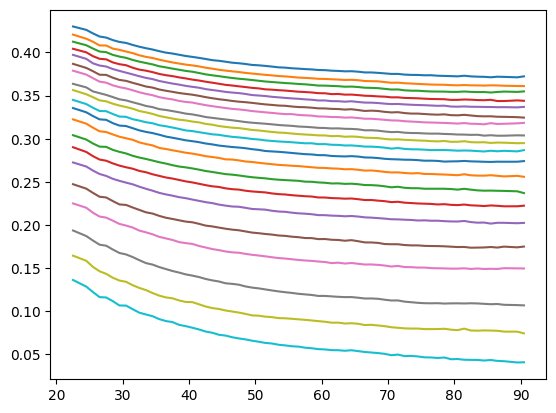

In [ ]:
for i in range(1, deformed_corr_2d_grid.shape[0]):
    r, c_r = compute_correlation(corr_2d_grid[0], x_seps, y_seps, 1, 128, 128)
    r, c_d_r = compute_correlation(deformed_corr_2d_grid[i], x_seps, y_seps, 1, 128, 128)
    plt.plot(r, [sum(c) / len(c) for c in c_d_r])
    # plt.show()
# plt.plot(r, [sum(c)/len(c) for c in c_r])

In [ ]:
max(r)

np.float64(90.75)